# Check GPU

In [ ]:
!nvidia-smi

Wed Sep  4 07:59:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct
# https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 26.62 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
!nvidia-smi

Wed Sep  4 07:59:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
filenames = [data_dir + filename for filename in os.listdir(data_dir) if filename.endswith('.txt')]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Helper Functions

In [ ]:
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Visualization

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()


In [ ]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples=[]

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = '' # Resetting for a start of a new line.

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split)-1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

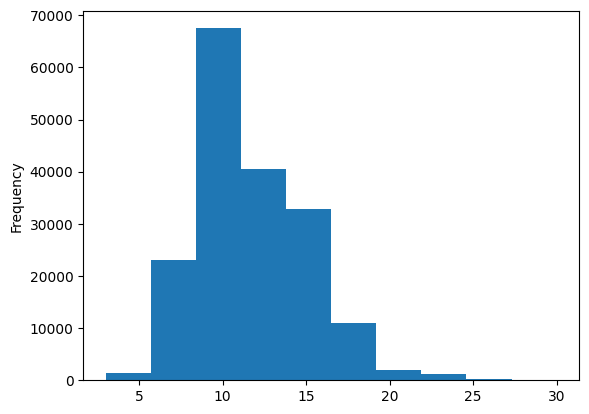

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
# Convert abstract text lines into into lines
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# One Hot Ecoding Text

In [ ]:
# Converting sentences to numbers
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder_1 = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder_1.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder_1.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder_1.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

# Label Encoding Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_label_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_label_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())


In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Baseline model

Using TF-IDF Multinomial Naive Bayes Classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_label_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(val_sentences, val_label_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)

In [ ]:
baseline_results = calculate_results(val_label_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Vectorization of input data

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
sent_length = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_length)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

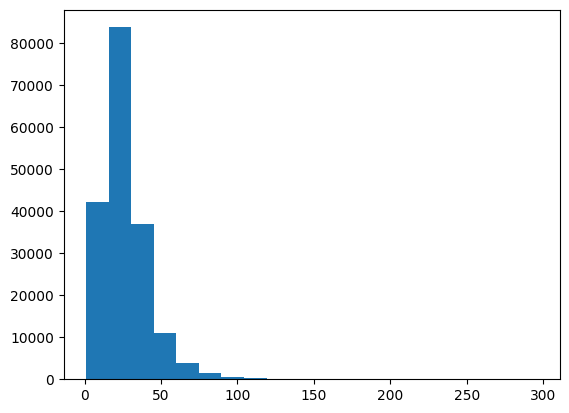

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_length, bins=20)

In [ ]:
# Getting length that is greater than 95% of sentence lengths
output_seq_len = int(np.percentile(sent_length, 95))
output_seq_len

55

In [ ]:
max(sent_length)

296

In [ ]:
#(taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 70000 # Rounding off to nearest 10k

In [ ]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f'Text: \n{target_sentence}')
print(f'\nLength of text:{len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text: 
there was a significant difference in favour of air-polishing for the perception of pain/discomfort .

Length of text:15

Vectorized text: [[   61    10     8    37    74     5  4243     4 27532    11     2  1569
      4 13092     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
text_vocab = text_vectorizer.get_vocabulary()
len(text_vocab)
print(f'Most common words: {text_vocab[:5]}')
print(f'Least common words: {text_vocab[-5:]}')

Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'of',
 'in',
 'to',
 'with',
 'a',
 'were',
 'was',
 'for',
 'patients',
 'group',
 'p',
 'at',
 'or',
 'study',
 'on',
 'treatment',
 'is',
 'after',
 'by',
 'this',
 'groups',
 'as',
 'an',
 'from',
 'that',
 'randomized',
 'between',
 'not',
 'trial',
 'no',
 'compared',
 'control',
 'be',
 'significant',
 'intervention',
 'significantly',
 'n',
 'months',
 'than',
 'we',
 'vs',
 'rsb',
 'lsb',
 'clinical',
 'placebo',
 'baseline',
 'ci',
 'two',
 'during',
 'weeks',
 'both',
 'had',
 'primary',
 'mean',
 'are',
 'using',
 'participants',
 'there',
 'all',
 'time',
 'years',
 'pain',
 'therapy',
 'who',
 'mg',
 'more',
 'effect',
 'effects',
 'but',
 'risk',
 'difference',
 'outcomes',
 'total',
 'care',
 'rate',
 'efficacy',
 'received',
 'associated',
 'higher',
 'respectively',
 'days',
 'analysis',
 'outcome',
 'use',
 'one',
 'week',
 'women',
 'may',
 'randomly',
 'levels',
 'followup',
 'will',
 'increased',
 'health',
 'used',
 'have',
 'data'

In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 70000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

# Create Text Embedding

In [ ]:
token_embed = layers.Embedding(input_dim=len(text_vocab),
                                output_dim=128,
                                mask_zero=True,
                                name='token_embedding')

In [ ]:
print(f'Before: {target_sentence}')
print(f'After: {text_vectorizer([target_sentence])}')
print(f'Embedded: {token_embed(text_vectorizer([target_sentence]))}')
token_embed(text_vectorizer([target_sentence])).shape

Before: there was a significant difference in favour of air-polishing for the perception of pain/discomfort .
After: [[   61    10     8    37    74     5  4243     4 27532    11     2  1569
      4 13092     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Embedded: [[[ 2.6792172e-02  1.3678614e-02  3.5778020e-02 ... -4.5493413e-02
   -1.8931925e-05 -2.9292926e-03]
  [ 4.1202668e-02  3.5801005e-02 -3.5221230e-02 ... -9.2984065e-03
    1.9666780e-02  5.0609820e-03]
  [ 4.6147816e-03 -2.6575958e-02 -8.3484277e-03 ... -2.8588211e-02
   -4.0381014e-02  2.3816537e-02]
  ...
  [ 2.6209090e-02  1.6445924e-02 -4.1726828e-03 ...  5.6860335e-03
   -4.8894893e-02 -3.0555917e-02]
  [ 2.6209090e-02  1.6445924e-02 -4.1726828e-03 ...  5.6860335e-03
   -4.8894893e-02 -3.0555917e-02]
  [ 2.6209090e-02  1

TensorShape([1, 55, 128])

# Fast Loadimg

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Conv1D model

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                             

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=10,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 25s 40ms/step - loss: 0.8269 - accuracy: 0.6808 - val_loss: 0.5861 - val_accuracy: 0.7796
Epoch 2/10
562/562 [==============================] - 11s 20ms/step - loss: 0.5783 - accuracy: 0.7895 - val_loss: 0.5463 - val_accuracy: 0.7945
Epoch 3/10
562/562 [==============================] - 4s 8ms/step - loss: 0.5436 - accuracy: 0.7999 - val_loss: 0.5194 - val_accuracy: 0.8105
Epoch 4/10
562/562 [==============================] - 4s 6ms/step - loss: 0.5245 - accuracy: 0.8087 - val_loss: 0.5216 - val_accuracy: 0.8045
Epoch 5/10
562/562 [==============================] - 5s 9ms/step - loss: 0.5324 - accuracy: 0.8066 - val_loss: 0.5009 - val_accuracy: 0.8162
Epoch 6/10
562/562 [==============================] - 4s 8ms/step - loss: 0.5241 - accuracy: 0.8058 - val_loss: 0.4978 - val_accuracy: 0.8228
Epoch 7/10
562/562 [==============================] - 5s 8ms/step - loss: 0.5000 - accuracy: 0.8131 - val_loss: 0.4834 - val_accuracy: 0.8251
Ep

In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4721 - accuracy: 0.8277


[0.4721243381500244, 0.8276843428611755]

In [ ]:
model_1_results = calculate_results(val_label_encoded, tf.argmax(model_1.predict(valid_dataset), axis=1))
model_1_results

945/945 [==============================] - 2s 2ms/step


{'accuracy': 82.76843638289422,
 'precision': 0.8243403728911385,
 'recall': 0.8276843638289422,
 'f1': 0.82480239587185}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 2, Conv1D with character embeddings

## Creating a character level tokenizer

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
def get_characters(text):
  return ' '.join(list(text))

In [ ]:
train_chars = [get_characters(sentence) for sentence in train_sentences]
val_chars = [get_characters(sentence) for sentence in val_sentences]
test_chars = [get_characters(sentence) for sentence in test_sentences]

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

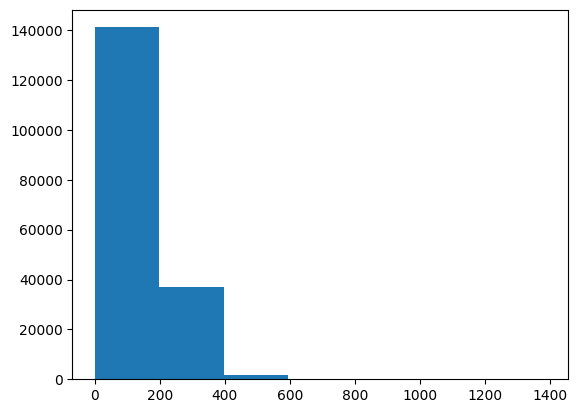

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
plt.hist(char_lens, bins=7)

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
random.choice(train_sentences)

'this is a prospective , comparative , blinded , and randomized clinical trial with @ groups that will receive distinct interventions .'

In [ ]:
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
NUM_CHAR_TOKENS = len(alphabet)+2 # 2 of OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)
char_vocab=char_vectorizer.get_vocabulary()
print(f'length: \n{len(char_vocab)}')
print(char_vocab[:5])
print(char_vocab[-5:])

length: 
28
['', '[UNK]', 'e', 't', 'i']
['k', 'x', 'z', 'q', 'j']


In [ ]:
random_rain_chars = random.choice(train_chars)
print(f'Text: \n{random_rain_chars}')
print(f'\nLength of text:{len(random_rain_chars.split())}')
print(f'\nVectorized text: {char_vectorizer([random_rain_chars])}')
print(f'\nLength of text:{len(char_vectorizer([random_rain_chars])[0])}')

Text: 
a   n u m b e r   o f   e f f e c t i v e   s t r a t e g i e s   h a v e   b e e n   d e v e l o p e d   t o   i m p r o v e   t h e   q u a l i t y   o f   l i f e   i n   p a t i e n t s   w i t h   c o p d   .

Length of text:89

Vectorized text: [[ 5  6 16 15 22  2  8  7 17  2 17 17  2 11  3  4 21  2  9  3  8  5  3  2
  18  4  2  9 13  5 21  2 22  2  2  6 10  2 21  2 12  7 14  2 10  3  7  4
  15 14  8  7 21  2  3 13  2 26 16  5 12  4  3 19  7 17 12  4 17  2  4  6
  14  5  3  4  2  6  3  9 20  4  3 13 11  7 14 10  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

### Character level embedding

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name='char_embedding_layer')


In [ ]:
print(f'Text: \n{random_rain_chars}')
print(f'\nLength of text:{len(random_rain_chars.split())}')
print(f'\nVectorized text: {char_vectorizer([random_rain_chars])}')
print(f'\nLength of text:{len(char_vectorizer([random_rain_chars])[0])}')
print(f'Embedded: {char_embed(char_vectorizer([random_rain_chars]))}')
print(f'\nLength of text:{(char_embed(char_vectorizer([random_rain_chars])).shape)}')

Text: 
a   n u m b e r   o f   e f f e c t i v e   s t r a t e g i e s   h a v e   b e e n   d e v e l o p e d   t o   i m p r o v e   t h e   q u a l i t y   o f   l i f e   i n   p a t i e n t s   w i t h   c o p d   .

Length of text:89

Vectorized text: [[ 5  6 16 15 22  2  8  7 17  2 17 17  2 11  3  4 21  2  9  3  8  5  3  2
  18  4  2  9 13  5 21  2 22  2  2  6 10  2 21  2 12  7 14  2 10  3  7  4
  15 14  8  7 21  2  3 13  2 26 16  5 12  4  3 19  7 17 12  4 17  2  4  6
  14  5  3  4  2  6  3  9 20  4  3 13 11  7 14 10  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

In [ ]:
# Conv1D model

inputs = layers.Input(shape=(1,), dtype='string')
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation='relu')(char_embedding)
# x = layers.GlobalAveragePooling1D()(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_conv1d')

#Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embedding_layer (Embe  (None, 290, 25)           700       
 dding)                                                          
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                    

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_2_history = model_2.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=10,
                              validation_data=valid_char_dataset,
                              validation_steps=int(0.1*len(valid_char_dataset)))

Epoch 1/10
562/562 [==============================] - 5s 6ms/step - loss: 1.2566 - accuracy: 0.4805 - val_loss: 1.0494 - val_accuracy: 0.5791
Epoch 2/10
562/562 [==============================] - 3s 5ms/step - loss: 1.0177 - accuracy: 0.5891 - val_loss: 0.9558 - val_accuracy: 0.6180
Epoch 3/10
562/562 [==============================] - 3s 5ms/step - loss: 0.9427 - accuracy: 0.6292 - val_loss: 0.8888 - val_accuracy: 0.6466
Epoch 4/10
562/562 [==============================] - 4s 7ms/step - loss: 0.8939 - accuracy: 0.6508 - val_loss: 0.8630 - val_accuracy: 0.6582
Epoch 5/10
562/562 [==============================] - 3s 5ms/step - loss: 0.8750 - accuracy: 0.6557 - val_loss: 0.8372 - val_accuracy: 0.6762
Epoch 6/10
562/562 [==============================] - 3s 5ms/step - loss: 0.8623 - accuracy: 0.6623 - val_loss: 0.8096 - val_accuracy: 0.6888
Epoch 7/10
562/562 [==============================] - 3s 5ms/step - loss: 0.8391 - accuracy: 0.6752 - val_loss: 0.7967 - val_accuracy: 0.6915
Epoch 

In [ ]:
model_2_pred = tf.argmax(model_2.predict(valid_char_dataset), axis=1)
model_2_result = calculate_results(val_label_encoded,
                                   model_2_pred)
model_2_result

945/945 [==============================] - 3s 3ms/step


{'accuracy': 70.47199788163644,
 'precision': 0.6977254867158423,
 'recall': 0.7047199788163644,
 'f1': 0.6984154485554218}

# Model 3: Token Embedding + Character Embedding

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name='token_input')
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
token_outputs = layers.Dense(128, activation='relu')(x)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layer
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Combine into one model
model_3 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_3_hybrid_embedding')


In [ ]:
model_3.summary()

Model: "model_3_hybrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 token_embedding (Embedding  (None, 55, 128)              8299648   ['text_vectorization[1][0]']  
 )                                                                                                
                                                                           

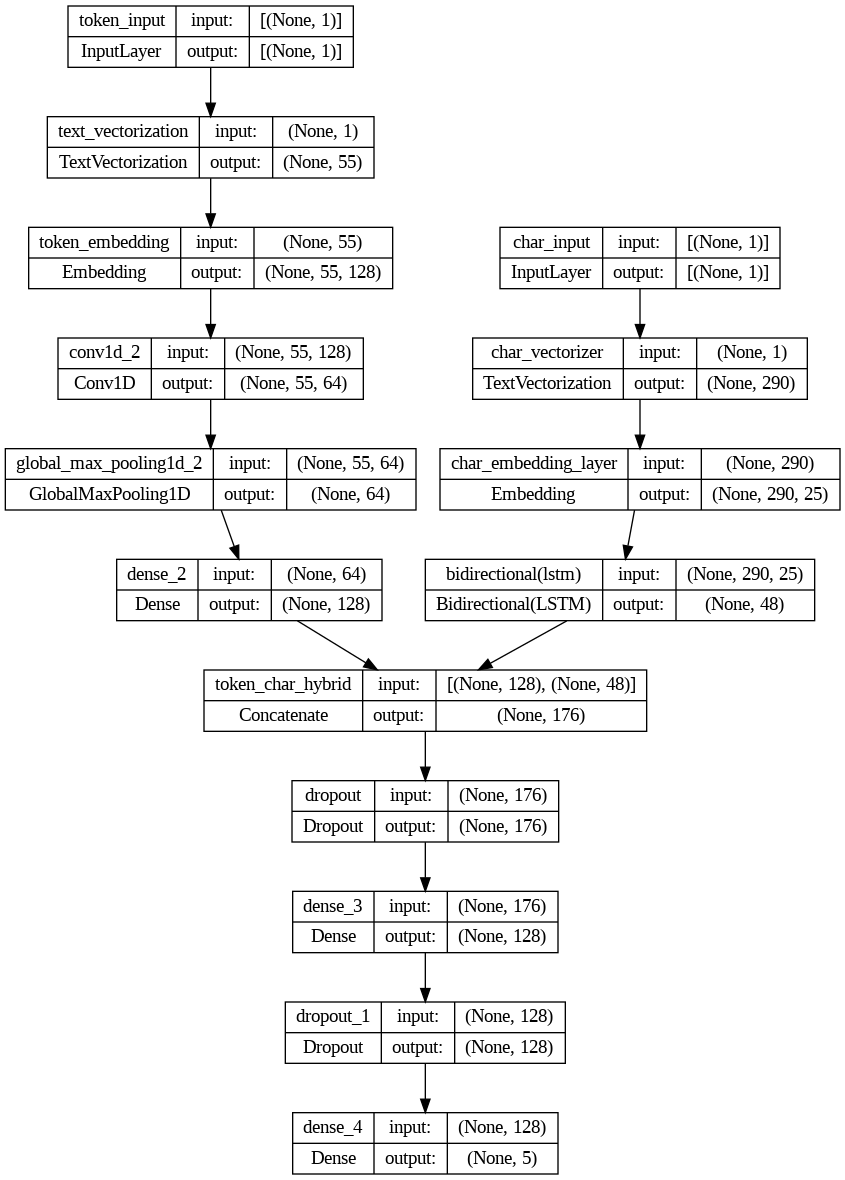

In [ ]:
from keras.utils import plot_model
plot_model(model_3, show_shapes=True)

In [ ]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Create data pipeline
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = tf.data.Dataset.zip(train_token_char_data, train_token_char_labels).batch(32).prefetch(tf.data.AUTOTUNE)

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip(val_token_char_data, val_token_char_labels).batch(32).prefetch(tf.data.AUTOTUNE)

test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_token_char_dataset = tf.data.Dataset.zip(test_token_char_data, test_token_char_labels).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model_3_historys = model_3.fit(train_token_char_dataset,
                               steps_per_epoch = int(0.1*len(train_token_char_dataset)),
                               epochs=10,
                               validation_data=val_token_char_dataset,
                               validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/10
562/562 [==============================] - 50s 69ms/step - loss: 0.6898 - accuracy: 0.7403 - val_loss: 0.5115 - val_accuracy: 0.8162
Epoch 2/10
562/562 [==============================] - 22s 40ms/step - loss: 0.5188 - accuracy: 0.8201 - val_loss: 0.5253 - val_accuracy: 0.8052
Epoch 3/10
562/562 [==============================] - 20s 36ms/step - loss: 0.4895 - accuracy: 0.8282 - val_loss: 0.5006 - val_accuracy: 0.8132
Epoch 4/10
562/562 [==============================] - 23s 41ms/step - loss: 0.4703 - accuracy: 0.8377 - val_loss: 0.5002 - val_accuracy: 0.8128
Epoch 5/10
562/562 [==============================] - 20s 36ms/step - loss: 0.4806 - accuracy: 0.8357 - val_loss: 0.4944 - val_accuracy: 0.8198
Epoch 6/10
562/562 [==============================] - 22s 40ms/step - loss: 0.4748 - accuracy: 0.8329 - val_loss: 0.4868 - val_accuracy: 0.8235
Epoch 7/10
562/562 [==============================] - 24s 43ms/step - loss: 0.4501 - accuracy: 0.8400 - val_loss: 0.5101 - val_accuracy:

In [ ]:
model_3.evaluate(test_token_char_dataset)

942/942 [==============================] - 12s 13ms/step - loss: 0.5115 - accuracy: 0.8164


[0.5114763975143433, 0.8163596987724304]

In [ ]:
model_3_pred = tf.argmax(model_3.predict(test_token_char_dataset), axis=1)
model_3_results = calculate_results(test_label_encoded,
                                    model_3_pred)

942/942 [==============================] - 14s 12ms/step


In [ ]:
model_3_results

{'accuracy': 81.63597146175543,
 'precision': 0.8136733062183897,
 'recall': 0.8163597146175543,
 'f1': 0.8134434191778255}

In [ ]:
model_2_result

{'accuracy': 70.47199788163644,
 'precision': 0.6977254867158423,
 'recall': 0.7047199788163644,
 'f1': 0.6984154485554218}

In [ ]:
model_1_results

{'accuracy': 82.76843638289422,
 'precision': 0.8243403728911385,
 'recall': 0.8276843638289422,
 'f1': 0.82480239587185}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model 4: Token Embedding + Character Embedding + Positional Embedding

### Model Checkpoint

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=3,
                                         restore_best_weights=True)

### Create Positional Embeddings

In [ ]:
# How many different line numbers are there:
train_df['line_number'].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

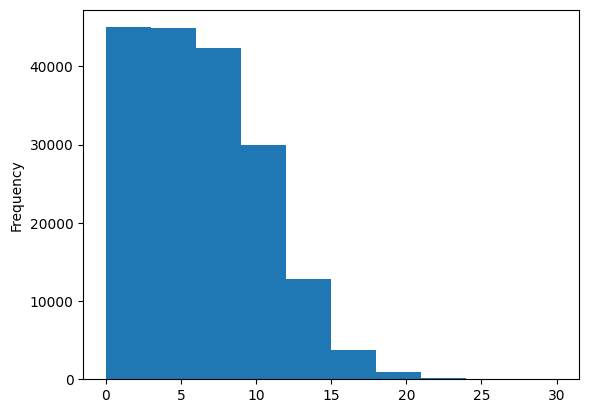

In [ ]:
train_df['line_number'].plot.hist()

In [ ]:
np.percentile(train_df.line_number, 98)

15.0

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
# total lines
train_df['total_lines'].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

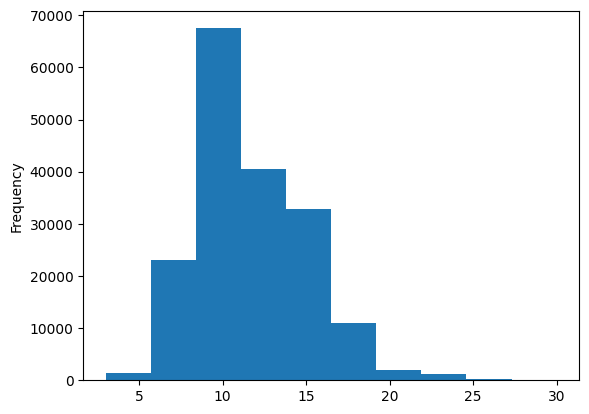

In [ ]:
train_df['total_lines'].plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [ ]:
# Building Tribrid embedding model

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name='token_input')
token_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPooling1D()(x)
token_outputs = layers.Dense(128, activation='relu')(x)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Setup line number inputs/model

line_number_layer = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x=layers.Dense(32, activation='relu')(line_number_layer)
line_number_model = tf.keras.Model(line_number_layer, x)

# 4. Setup total lines inputs/model

total_lines_layer = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
x=layers.Dense(32, activation='relu')(total_lines_layer)
total_lines_model = tf.keras.Model(total_lines_layer, x)

# 5. Combine token and char embedding into hybrid embeddings
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 6. Create output layer for token-char model after Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 7. Combine positional embedding with token char hybrid embedding
tribrid_embedding = layers.Concatenate(name='char_token_position_tribrid')([line_number_model.output,
                                                                            total_lines_model.output,
                                                                            output_layer])

# 8. Create Output Layer
tribrid_embedding = tf.expand_dims(tribrid_embedding, axis=1)
layer = layers.Bidirectional(layers.LSTM(256))(tribrid_embedding)
combined_dropout = layers.Dropout(0.5)(layer)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_dropout)

model_4 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                                 outputs=output_layer,
                                 name='tribrid_embedding_model')



In [ ]:
model_4.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 55)                   0         ['token_input[0][0]']         
 ctorization)                                                                                     
                                                                                                  
 token_embedding (Embedding  (None, 55, 128)              8299648   ['text_vectorization[2][0]']  
 )                                                                                                
                                                                            

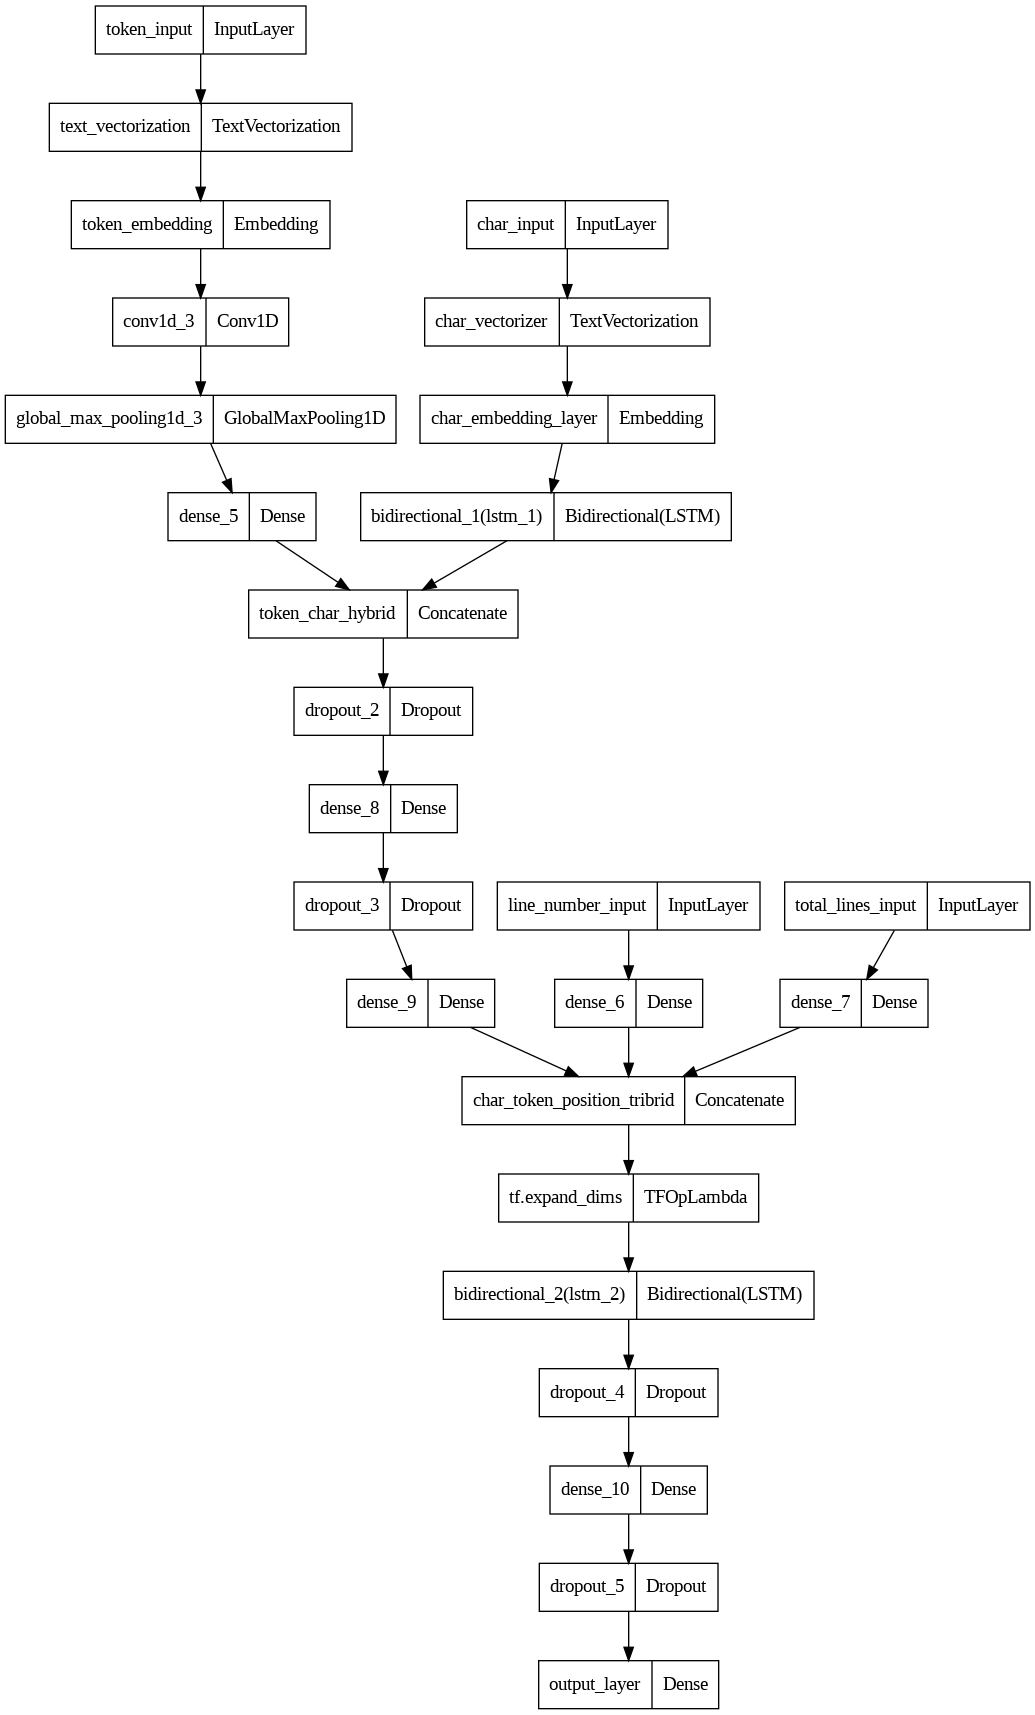

In [ ]:
plot_model(model_4)

In [ ]:
# Compile

model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:

# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_4 = model_4.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
                              callbacks=[callback])

Epoch 1/10
562/562 [==============================] - 56s 74ms/step - loss: 1.0914 - accuracy: 0.7021 - val_loss: 0.9282 - val_accuracy: 0.8045
Epoch 2/10
562/562 [==============================] - 26s 46ms/step - loss: 0.9202 - accuracy: 0.8365 - val_loss: 0.9080 - val_accuracy: 0.8308
Epoch 3/10
562/562 [==============================] - 23s 41ms/step - loss: 0.8962 - accuracy: 0.8484 - val_loss: 0.8976 - val_accuracy: 0.8334
Epoch 4/10
562/562 [==============================] - 25s 45ms/step - loss: 0.8907 - accuracy: 0.8551 - val_loss: 0.8900 - val_accuracy: 0.8334
Epoch 5/10
562/562 [==============================] - 24s 43ms/step - loss: 0.8835 - accuracy: 0.8583 - val_loss: 0.8814 - val_accuracy: 0.8374
Epoch 6/10
562/562 [==============================] - 24s 43ms/step - loss: 0.8843 - accuracy: 0.8568 - val_loss: 0.8774 - val_accuracy: 0.8481
Epoch 7/10
562/562 [==============================] - 28s 49ms/step - loss: 0.8730 - accuracy: 0.8689 - val_loss: 0.8770 - val_accuracy:

In [ ]:
model_4.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.8793 - accuracy: 0.8494


[0.8792526125907898, 0.8493645191192627]

In [ ]:
model_4_pred_probs = tf.argmax(model_4.predict(test_pos_char_token_dataset, verbose=1), axis=1)
model_4_pred_probs

942/942 [==============================] - 49s 15ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=test_label_encoded,
                                    y_pred=model_4_pred_probs)
model_4_results

{'accuracy': 84.47652231624357,
 'precision': 0.8452378346976795,
 'recall': 0.8447652231624357,
 'f1': 0.8434445888670227}

# Model 5: Token Embedding (via Universal Sentence Encoder) + Character Embedding + Positional Embedding

In [ ]:
import tensorflow_hub as hub
embed = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Building Tribrid embedding model

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embed = embed(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embed)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=[], dtype=tf.string, name='char_input')
char_embedding = embed(char_inputs)
char_embedding = tf.expand_dims(char_embedding, axis=1)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Setup line number inputs/model

line_number_layer = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x=layers.Dense(32, activation='relu')(line_number_layer)
line_number_model = tf.keras.Model(line_number_layer, x)

# 4. Setup total lines inputs/model

total_lines_layer = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
x=layers.Dense(32, activation='relu')(total_lines_layer)
total_lines_model = tf.keras.Model(total_lines_layer, x)

# 5. Combine token and char embedding into hybrid embeddings
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 6. Create output layer for token-char model after Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 7. Combine positional embedding with token char hybrid embedding
tribrid_embedding = layers.Concatenate(name='char_token_position_tribrid')([line_number_model.output,
                                                                            total_lines_model.output,
                                                                            output_layer])

# 8. Create Output Layer
tribrid_embedding = tf.expand_dims(tribrid_embedding, axis=1)
layer = layers.Bidirectional(layers.LSTM(256))(tribrid_embedding)
combined_dropout = layers.Dropout(0.5)(layer)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_dropout)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                                 outputs=output_layer,
                                 name='tribrid_embedding_model')



In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]',         
  (KerasLayer)                                            24         'char_input[0][0]']          
                                                                                                  
 tf.expand_dims_1 (TFOpLamb  (None, 1, 512)               0         ['univer

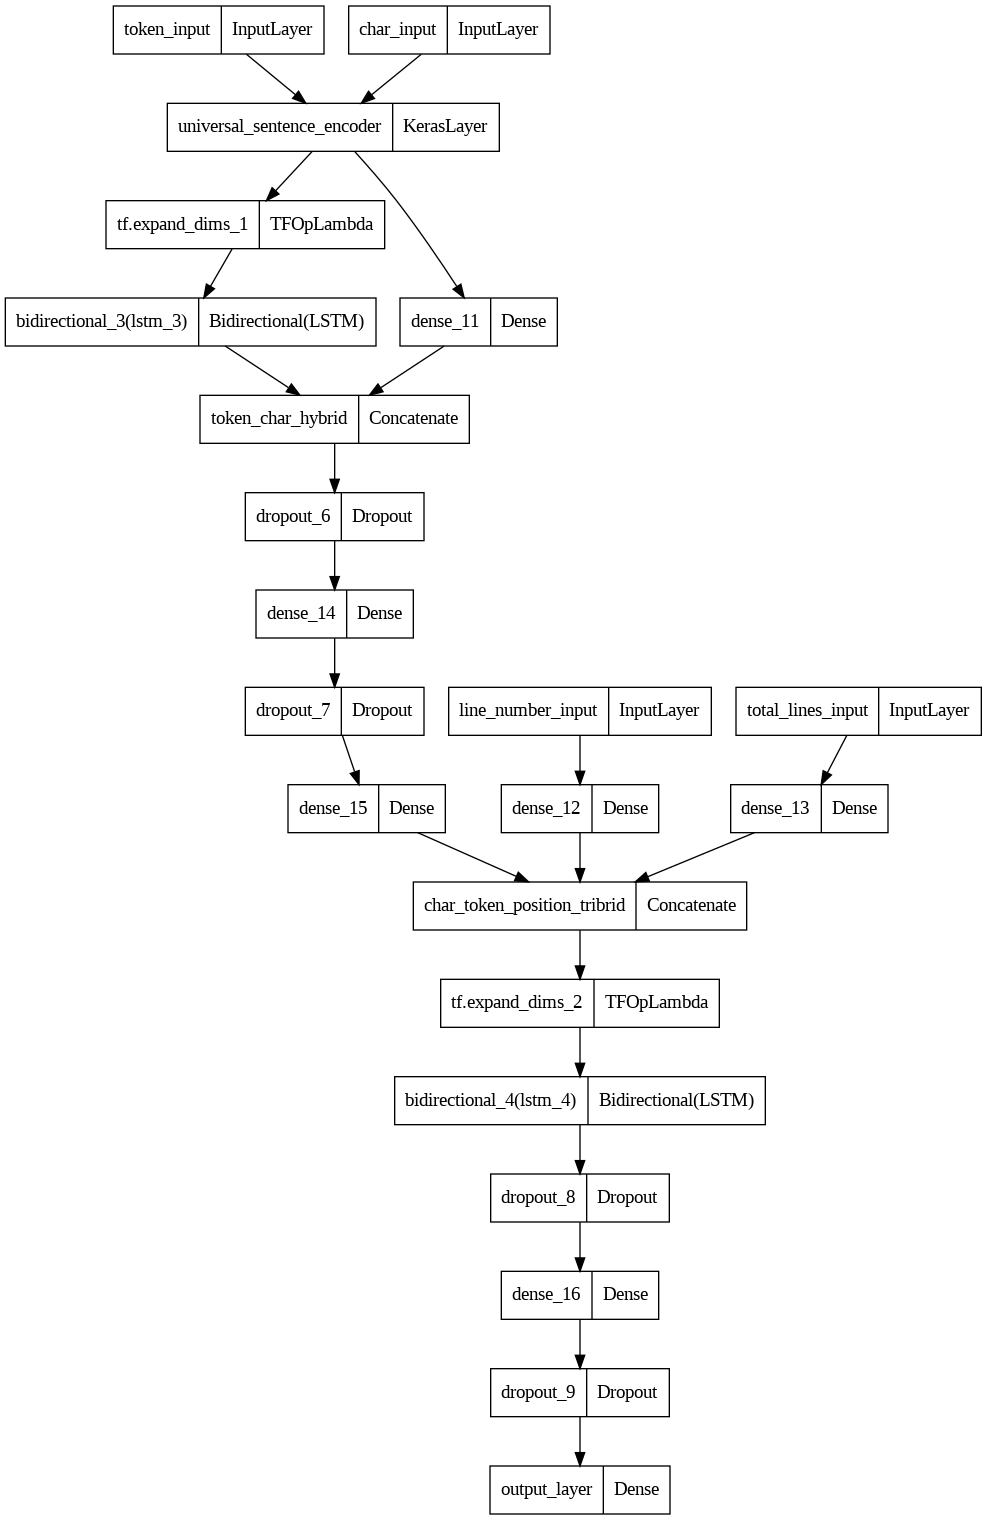

In [ ]:
plot_model(model_5)

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
                              callbacks=[callback])

Epoch 1/10
562/562 [==============================] - 43s 50ms/step - loss: 1.1756 - accuracy: 0.6371 - val_loss: 1.0170 - val_accuracy: 0.7530
Epoch 2/10
562/562 [==============================] - 27s 49ms/step - loss: 1.0184 - accuracy: 0.7641 - val_loss: 0.9628 - val_accuracy: 0.7906
Epoch 3/10
562/562 [==============================] - 25s 44ms/step - loss: 0.9877 - accuracy: 0.7870 - val_loss: 0.9388 - val_accuracy: 0.8015
Epoch 4/10
562/562 [==============================] - 24s 42ms/step - loss: 0.9735 - accuracy: 0.7958 - val_loss: 0.9282 - val_accuracy: 0.8118
Epoch 5/10
562/562 [==============================] - 24s 42ms/step - loss: 0.9665 - accuracy: 0.8023 - val_loss: 0.9188 - val_accuracy: 0.8155
Epoch 6/10
562/562 [==============================] - 25s 45ms/step - loss: 0.9661 - accuracy: 0.8004 - val_loss: 0.9121 - val_accuracy: 0.8211
Epoch 7/10
562/562 [==============================] - 25s 45ms/step - loss: 0.9523 - accuracy: 0.8075 - val_loss: 0.9059 - val_accuracy:

In [ ]:
model_5_pred_probs = tf.argmax(model_5.predict(test_pos_char_token_dataset, verbose=1), axis=1)
model_5_pred_probs

942/942 [==============================] - 28s 28ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 4])>

In [ ]:
model_5_results = calculate_results(y_true=test_label_encoded,
                                    y_pred=model_5_pred_probs)
model_5_results

{'accuracy': 82.57839721254355,
 'precision': 0.8241494518635197,
 'recall': 0.8257839721254355,
 'f1': 0.8166334116862802}

# Model 6: Token Embedding (via USE) + Character Embedding + Positional Embedding + Line Relation

In [ ]:
train_df['line_number_total'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)
val_df['line_number_total'] = val_df['line_number'].astype(str) + '_of_' + val_df['total_lines'].astype(str)
test_df['line_number_total'] = test_df['line_number'].astype(str) + '_of_' + test_df['total_lines'].astype(str)

train_df.head(10)

,target,text,line_number,total_lines,line_number_total
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11,5_of_11
6,RESULTS,there was a clinically relevant reduction in t...,6,11,6_of_11
7,RESULTS,the mean difference between treatment arms ( @...,7,11,7_of_11
8,RESULTS,"further , there was a clinically relevant redu...",8,11,8_of_11
9,RESULTS,these differences remained significant at @ we...,9,11,9_of_11


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Creating an instance
one_hot_encoder = OneHotEncoder()

# Fitting on the training dataframe
one_hot_encoder.fit(np.expand_dims(train_df['line_number_total'] , axis = 1))

# Transforming both train and val df
train_line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(train_df['line_number_total'] , axis =1))
val_line_number_total_encoded  = one_hot_encoder.transform(np.expand_dims(val_df['line_number_total'] , axis= 1))
test_line_number_total_encoded  = one_hot_encoder.transform(np.expand_dims(test_df['line_number_total'] , axis= 1))

# Checking the shapes
train_line_number_total_encoded.shape , val_line_number_total_encoded.shape, test_line_number_total_encoded.shape

((180040, 460), (30212, 460), (30135, 460))

In [ ]:
train_line_number_total_encoded = train_line_number_total_encoded.toarray()
val_line_number_total_encoded = val_line_number_total_encoded.toarray()
test_line_number_total_encoded = test_line_number_total_encoded.toarray()

# Converting the datatype to int
train_line_number_total_encoded = tf.cast(train_line_number_total_encoded , dtype= tf.int32)
val_line_number_total_encoded = tf.cast(val_line_number_total_encoded , dtype= tf.int32)
test_line_number_total_encoded = tf.cast(test_line_number_total_encoded , dtype= tf.int32)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_sentences ,
                                                 train_chars ,
                                                 train_line_number_total_encoded,
                                                 train_line_numbers_one_hot,
                                                                train_total_lines_one_hot))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

val_data = tf.data.Dataset.from_tensor_slices((val_sentences ,
                                               val_chars ,
                                               val_line_number_total_encoded,
                                               val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,))

val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

test_data = tf.data.Dataset.from_tensor_slices((test_sentences ,
                                                test_chars ,
                                                test_line_number_total_encoded,
                                                test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,))

test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

# Zipping the data and labels
train_dataset = tf.data.Dataset.zip((train_data , train_labels))
val_dataset = tf.data.Dataset.zip((val_data , val_labels))
test_dataset = tf.data.Dataset.zip((test_data , test_labels))

# Applying batch and prefetching
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_dataset , val_dataset, test_dataset


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None), TensorSpec(shape=(None, 15), dtype=t

In [ ]:
embed.trainable=True

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embed = embed(token_inputs)
token_embedings = tf.expand_dims(token_embed, axis=1)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedings)
x = layers.GlobalMaxPooling1D()(x)
token_outputs = layers.Dense(128, activation='relu')(x)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=[], dtype=tf.string, name='char_input')
char_embedding = embed(char_inputs)
char_embedding = tf.expand_dims(char_embedding, axis=1)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

line_number_total_input = layers.Input(shape = (460,), dtype = tf.int32)
dense = layers.Dense(32 , activation = 'relu')(line_number_total_input)
total_line_number_model = tf.keras.Model(line_number_total_input , dense)

# Setup line number inputs/model

line_number_layer = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
x=layers.Dense(32, activation='relu')(line_number_layer)
line_number_model = tf.keras.Model(line_number_layer, x)

# Setup total lines inputs/model

total_lines_layer = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
x=layers.Dense(32, activation='relu')(total_lines_layer)
total_lines_model = tf.keras.Model(total_lines_layer, x)


# Concatenating the tokens amd chars output (Hybrid!!!)
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embedding')([token_model.output ,
                                                                                char_model.output])

# Combining the line_number_total to our hybrid model (Time for Tribid!!)
z = layers.Concatenate(name = 'tribid_embeddings')([total_line_number_model.output ,
                                                    line_number_model.output,
                                                    total_lines_model.output])

final_embeddings = layers.Concatenate(name = 'final_embeddings')([combined_embeddings , z])

# Adding a dense + dropout and creating our output layer
final_embeddings = tf.expand_dims(final_embeddings, axis=1)
layer = layers.Bidirectional(layers.LSTM(256))(final_embeddings)
combined_dropout = layers.Dropout(0.5)(layer)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_dropout)
# Packing into a model
model_6 = tf.keras.Model(inputs = [token_model.input ,
                                        char_model.input ,
                                        total_line_number_model.input,
                                        line_number_model.input,
                                        total_lines_model.input] ,
                              outputs = output_layer)

model_6.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]',         
  (KerasLayer)                                            24         'char_input[0][0]']          
                                                                                                  
 tf.expand_dims_3 (TFOpLamb  (None, 1, 512)               0         ['universal_sentence_encoder[2
 da)                                                                ][0]']                        
                                                                                           

In [ ]:
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

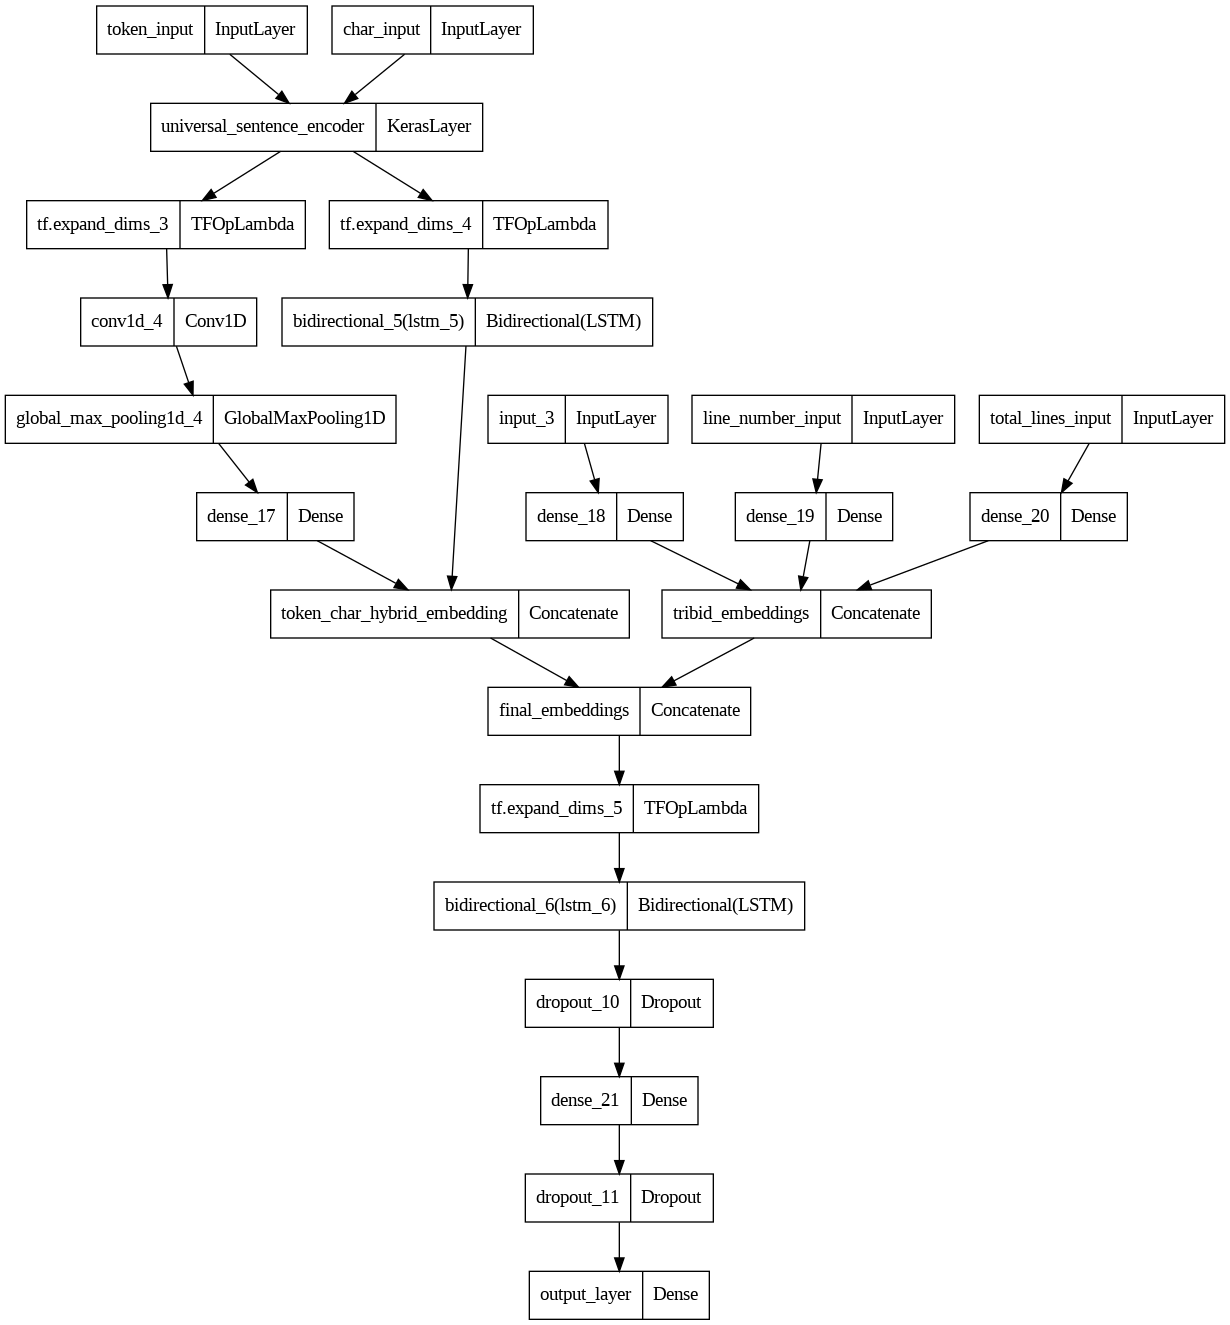

In [ ]:
plot_model(model_6)

In [ ]:
history_model_6 = model_6.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=10,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)),
                              callbacks=[callback])

Epoch 1/10
281/281 [==============================] - 191s 554ms/step - loss: 1.0662 - accuracy: 0.7279 - val_loss: 0.9010 - val_accuracy: 0.8331
Epoch 2/10
281/281 [==============================] - 49s 175ms/step - loss: 0.9143 - accuracy: 0.8426 - val_loss: 0.8890 - val_accuracy: 0.8514
Epoch 3/10
281/281 [==============================] - 46s 164ms/step - loss: 0.8913 - accuracy: 0.8585 - val_loss: 0.8606 - val_accuracy: 0.8767
Epoch 4/10
281/281 [==============================] - 41s 147ms/step - loss: 0.8797 - accuracy: 0.8727 - val_loss: 0.8487 - val_accuracy: 0.8773
Epoch 5/10
281/281 [==============================] - 40s 144ms/step - loss: 0.8743 - accuracy: 0.8761 - val_loss: 0.8465 - val_accuracy: 0.8777
Epoch 6/10
281/281 [==============================] - 41s 145ms/step - loss: 0.8772 - accuracy: 0.8738 - val_loss: 0.8379 - val_accuracy: 0.8850
Epoch 7/10
281/281 [==============================] - 41s 146ms/step - loss: 0.8648 - accuracy: 0.8823 - val_loss: 0.8453 - val_a

In [ ]:
model_6_pred_probs = tf.argmax(model_6.predict(test_dataset, verbose=1), axis=1)
model_6_pred_probs

471/471 [==============================] - 21s 40ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [ ]:
model_6_results = calculate_results(y_true=test_label_encoded,
                                    y_pred=model_6_pred_probs)
model_6_results

{'accuracy': 88.4685581549693,
 'precision': 0.8847674863062345,
 'recall': 0.884685581549693,
 'f1': 0.8830134782674915}

# Performance of all Models

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "model_1": model_1_results,
                                  "model_2": model_2_result,
                                  "model_3": model_3_results,
                                  "model_4": model_4_results,
                                  'model_5': model_5_results,
                                  'model_6': model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
model_1,82.768436,0.824340,0.827684,0.824802
model_2,70.471998,0.697725,0.704720,0.698415
model_3,81.635971,0.813673,0.816360,0.813443
model_4,84.476522,0.845238,0.844765,0.843445
model_5,82.578397,0.824149,0.825784,0.816633
model_6,88.468558,0.884767,0.884686,0.883013


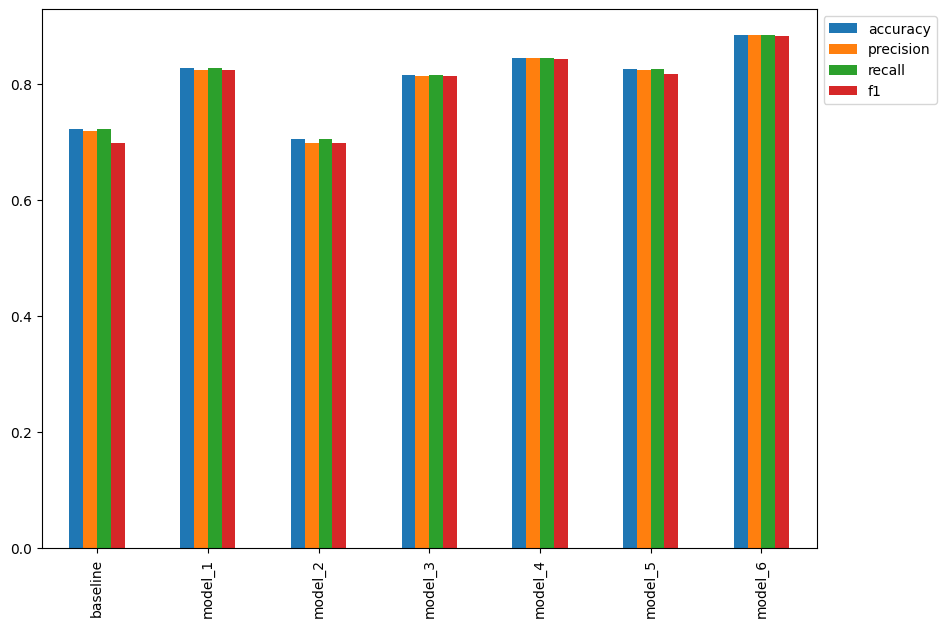

In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

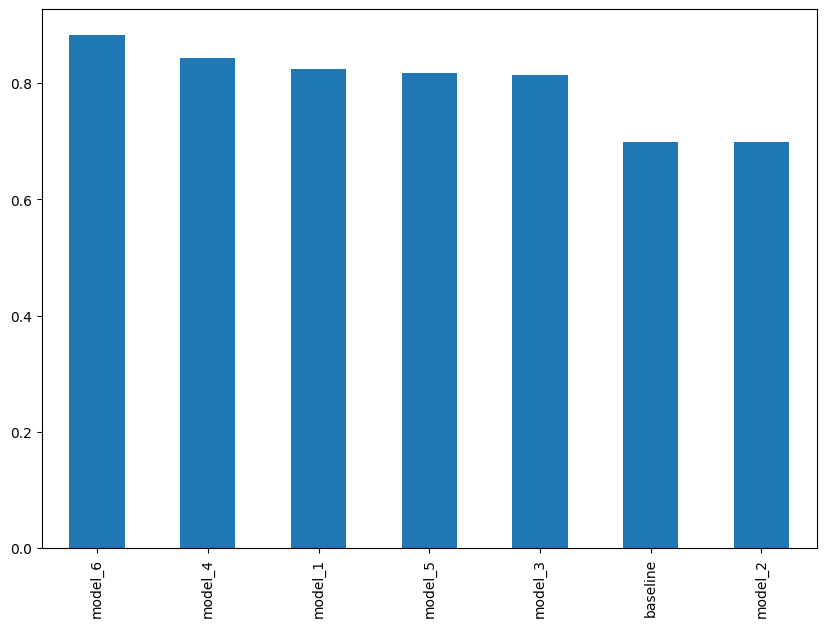

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

# Testing Model 6 - Our best performing model, on completely unseen data.

In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

import spacy
from spacy.lang.en import English

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
def visualize_pred_sequence_labels(abstract , model , label_encoder, line_encoder):

  '''

    Takes in a list of dictionaries of abstracts,

    [{'abstract': 'This RCT examined .......' ,
      'details': 'RCT of a manuali......',
      'source': 'https://pubmed.ncbi.nlm........./'},..........]

    Arguments:
    ----------
      - abstract_dict : Abstract dictionary of the above format
      - model : the trained model on the same data format (line_numbers,  total_lines , sentences , characters)
      - label_encoder : the label encoder used to encode the classes

    Returns:
    --------
      Prints out the predicted label and the corresponding sequence/ text
  '''

  # Setup english sentence parser
  nlp = English()

  # Create sentence splitting pipeline object
  nlp.add_pipe('sentencizer')

  # Create doc of parsed sequences
  doc = nlp(abstract)

  # Return detected sentences from doc in string typpe
  abstract_lines = [str(sent) for sent in list(doc.sents)]

  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Loop through each line in the abstract and create a list of dictionaries containing features
  sample_lines = []
  for i , line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict['text'] = str(line)
    sample_dict['line_number'] = i
    sample_dict['total_lines'] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)

  df = pd.DataFrame(sample_lines)
  df['line_number_total'] = df['line_number'].astype(str) + '_of_' + df['total_lines'].astype(str)
  encoded_line_number = line_encoder.transform(np.expand_dims(df['line_number_total'], axis=1))
  encoded_line_number = encoded_line_number.toarray()
  encoded_line_number = tf.cast(encoded_line_number, dtype=tf.int32)

  # Get all line number and total lines numbers then one hot encode them
  abstract_line_numbers = [line['line_number'] for line in sample_lines]
  abstract_total_lines = [line['total_lines'] for line in sample_lines]

  abstract_line_numbers_one_hot = tf.one_hot(abstract_line_numbers , depth = 15)
  abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines , depth = 20)


  # Split the lines into characters
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

  # Making prediction on sample features
  abstract_pred_probs = model.predict(x = (abstract_line_numbers_one_hot,
                                           abstract_total_lines_one_hot,
                                           tf.constant(abstract_lines) ,
                                           tf.constant(abstract_chars),
                                           ))

  # Turn prediction probs to pred class
  abstract_preds = tf.argmax(abstract_pred_probs , axis = 1)

  # Prediction class integers into string class name
  abstract_pred_classes = [label_encoder.classes_[i] for i in abstract_preds]

  # Prints out the abstract lines and the predicted sequence labels
  for i , line in enumerate(abstract_lines):
    print(f'{abstract_pred_classes[i]}:  {line}\n')

In [ ]:
# https://pubmed.ncbi.nlm.nih.gov/39181133/
abstract = 'Chromothripsis describes the catastrophic shattering of mis-segregated chromosomes trapped within micronuclei. Although micronuclei accumulate DNA double-strand breaks and replication defects throughout interphase, how chromosomes undergo shattering remains unresolved. Using CRISPR-Cas@ screens, we identify a non-canonical role of the Fanconi anemia (FA) pathway as a driver of chromothripsis. Inactivation of the FA pathway suppresses chromosome shattering during mitosis without impacting interphase-associated defects within micronuclei. Mono-ubiquitination of FANCI-FANCD@ by the FA core complex promotes its mitotic engagement with under-replicated micronuclear chromosomes. The structure-selective SLX@-XPF-ERCC@ endonuclease subsequently induces large-scale nucleolytic cleavage of persistent DNA replication intermediates, which stimulates POLD@-dependent mitotic DNA synthesis to prime shattered fragments for reassembly in the ensuing cell cycle. Notably, FA-pathway-induced chromothripsis generates complex genomic rearrangements and extrachromosomal DNA that confer acquired resistance to anti-cancer therapies. Our findings demonstrate how pathological activation of a central DNA repair mechanism paradoxically triggers cancer genome evolution through chromothripsis. '

In [ ]:
visualize_pred_sequence_labels(abstract , model_4 , label_encoder, one_hot_encoder)

1/1 [==============================] - 0s 77ms/step
BACKGROUND:  Chromothripsis describes the catastrophic shattering of mis-segregated chromosomes trapped within micronuclei.

BACKGROUND:  Although micronuclei accumulate DNA double-strand breaks and replication defects throughout interphase, how chromosomes undergo shattering remains unresolved.

BACKGROUND:  Using CRISPR-Cas@ screens, we identify a non-canonical role of the Fanconi anemia (FA) pathway as a driver of chromothripsis.

BACKGROUND:  Inactivation of the FA pathway suppresses chromosome shattering during mitosis without impacting interphase-associated defects within micronuclei.

CONCLUSIONS:  Mono-ubiquitination of FANCI-FANCD@ by the FA core complex promotes its mitotic engagement with under-replicated micronuclear chromosomes.

CONCLUSIONS:  The structure-selective SLX@-XPF-ERCC@ endonuclease subsequently induces large-scale nucleolytic cleavage of persistent DNA replication intermediates, which stimulates POLD@-depende

In [ ]:
model_6.save('model_6.keras')

In [ ]:
model = tf.keras.models.load_model('/content/model_6.keras')

In [ ]:
model.evaluate(test_pos_char_token_dataset)

942/942 [==============================] - 21s 16ms/step - loss: 0.8862 - accuracy: 0.8448


[0.8862451910972595, 0.8447652459144592]

In [ ]:
import pickle
with open("ohencoder", "wb") as f:
    pickle.dump(one_hot_encoder, f)

In [ ]:
with open("labelencoder", "wb") as f:
    pickle.dump(label_encoder, f)

In [ ]:
visualize_pred_sequence_labels(abstract , model , label_encoder, one_hot_encoder)

1/1 [==============================] - 3s 3s/step
BACKGROUND:  Chromothripsis describes the catastrophic shattering of mis-segregated chromosomes trapped within micronuclei.

BACKGROUND:  Although micronuclei accumulate DNA double-strand breaks and replication defects throughout interphase, how chromosomes undergo shattering remains unresolved.

BACKGROUND:  Using CRISPR-Cas@ screens, we identify a non-canonical role of the Fanconi anemia (FA) pathway as a driver of chromothripsis.

BACKGROUND:  Inactivation of the FA pathway suppresses chromosome shattering during mitosis without impacting interphase-associated defects within micronuclei.

CONCLUSIONS:  Mono-ubiquitination of FANCI-FANCD@ by the FA core complex promotes its mitotic engagement with under-replicated micronuclear chromosomes.

CONCLUSIONS:  The structure-selective SLX@-XPF-ERCC@ endonuclease subsequently induces large-scale nucleolytic cleavage of persistent DNA replication intermediates, which stimulates POLD@-dependent